# Laboratorio 02

In [237]:
import numpy as np
import skimage as sk
from matplotlib import pyplot as plt
import cv2 as cv

In [238]:
image_name = "person.png"

In [239]:
image = cv.imread(f'images/{image_name}', cv.IMREAD_GRAYSCALE)
# Convert to numpy array
image = np.array(image) / 255.0

## Inciso 1

In [240]:
def resize_image(image, k = 1):
		# (128k, 64k) is the new size of the image
		new_size = (int(128 * k), int(64 * k))
		# Resize the image
		image = sk.transform.resize(image, new_size, anti_aliasing=True)
		return image



In [241]:
resized_image = resize_image(image, 1)


## Inciso 2

In [242]:
from scipy.ndimage import convolve

def prewitt_operator(grayscale_image):
    # Kernels Perwitt
    Gx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    Gy = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    
    # Compute the gradient in the x and y directions
    grad_x = convolve(grayscale_image, Gx)
    grad_y = convolve(grayscale_image, Gy)
    
    # Compute the gradient magnitude
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    # Compute the gradient direction (angle)
    angle = np.arctan2(-grad_y, grad_x) * (180 / np.pi)
    # Ensure the angle is within 0 to 180 degrees
    angle[angle < 0] += 180
    angle = angle % 180
    
    return magnitude, angle

In [243]:
magnitude, angle = prewitt_operator(resized_image)


In [244]:
def generate_magnitude_and_angle_for_image(image_name, k=1):
		image = cv.imread(f'images/{image_name}', cv.IMREAD_GRAYSCALE)
		# Convert to numpy array
		image = np.array(image) / 255.0
		resized_image = resize_image(image, k)
		magnitude, angle = prewitt_operator(resized_image)
		return magnitude, angle


In [245]:
k = 1
magnitude, angle = generate_magnitude_and_angle_for_image(image_name, k)

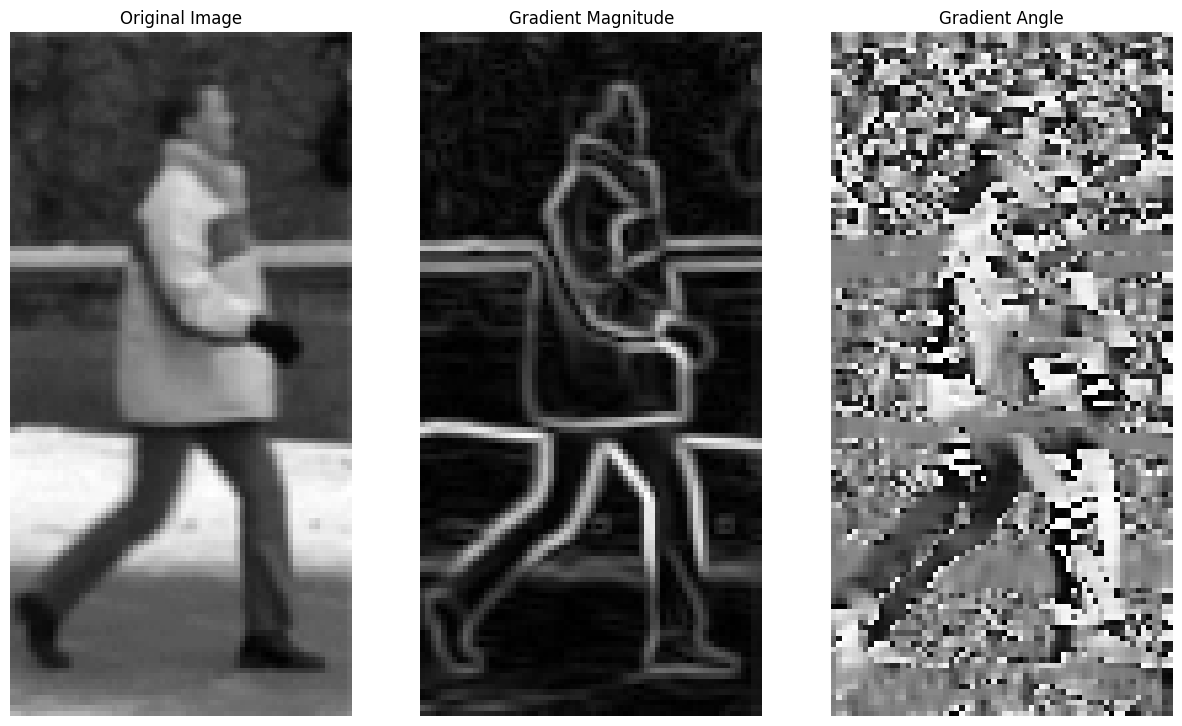

In [246]:
# Create a figure to display the results
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
ax = axes.ravel()
ax[0].imshow(resized_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(magnitude, cmap='gray')
ax[1].set_title('Gradient Magnitude')
ax[1].axis('off')
ax[2].imshow(angle, cmap='gray')
ax[2].set_title('Gradient Angle')
ax[2].axis('off')
plt.axis('off')
plt.show()

In [247]:
magnitude.shape

(128, 64)

In [248]:

def get_block(area, row_step, col_step, block_size): return area[row_step : row_step + block_size, col_step : col_step + block_size]

def gen_blocks_stacks(magnitude, angle, block_size):
    
    WIDTH, HEIGHT = magnitude.shape
    STRIDE = block_size // 2
    M = int((WIDTH / STRIDE) - 1)
    N = int((HEIGHT / STRIDE) - 1)

    blocks_magnitude = np.zeros((M, N, block_size, block_size))
    blocks_angle = np.zeros((M, N, block_size, block_size))


    for i in range(M):
        for j in range(N):
            row_step = i * STRIDE
            col_step = j * STRIDE

            blocks_magnitude[i, j] = get_block(magnitude, row_step, col_step, block_size)
            blocks_angle[i, j] = get_block(angle, row_step, col_step, block_size)

            
    return blocks_magnitude, blocks_angle

block_size = 15
blocks_magnitude, blocks_angle = gen_blocks_stacks(magnitude, angle, block_size)

In [249]:
blocks_magnitude.shape

(17, 8, 15, 15)

In [250]:
def build_histograms(m_bstack, a_bstack, n_bins):
    M, N, block_size, _ = m_bstack.shape
    histograms = np.zeros((M, N, n_bins))
    bin_centers = np.linspace(0, 180, n_bins, endpoint=False)

    for i in range(M):
        for j in range(N):
            m_block = m_bstack[i, j]
            a_block = a_bstack[i, j]
            histogram = np.zeros(n_bins)

            for k in range(block_size):
                for l in range(block_size):
                    angle = a_block[k, l]
                    magnitude = m_block[k, l]
                    
                    new_magnitude = None
                    angle_diff = np.abs(angle - bin_centers)
                    for idx, _ in enumerate(angle_diff):
                        if idx < len(angle_diff) - 1 and angle_diff[idx] == angle_diff[idx + 1]:
                            new_magnitude = magnitude / 2
                            histogram[idx] += new_magnitude
                            histogram[idx + 1] += new_magnitude
                            break
                    
                    if new_magnitude == None:
                        idx = np.argmin(angle_diff)
                        histogram[idx] += magnitude

            histogram = histogram / np.linalg.norm(histogram)
            histograms[i, j] = histogram            

    return histograms

n_bins = 9
histograms = build_histograms(blocks_magnitude, blocks_angle, n_bins)

In [251]:
histograms.shape

(17, 8, 9)

In [252]:
histograms

array([[[0.12566017, 0.30603941, 0.3315225 , ..., 0.41192574,
         0.2746121 , 0.20324133],
        [0.12993956, 0.26360074, 0.24897939, ..., 0.31899604,
         0.42874185, 0.29820302],
        [0.09218626, 0.26456104, 0.21200901, ..., 0.40737005,
         0.35294759, 0.35188349],
        ...,
        [0.10651015, 0.24591421, 0.13994553, ..., 0.2512052 ,
         0.32992544, 0.64719334],
        [0.05186609, 0.28216096, 0.26523394, ..., 0.40434505,
         0.36303313, 0.29033458],
        [0.12097439, 0.33301837, 0.50839857, ..., 0.16370104,
         0.36975892, 0.50795861]],

       [[0.1300743 , 0.38761146, 0.34416584, ..., 0.44083237,
         0.26772075, 0.39016729],
        [0.17577416, 0.40163936, 0.3452175 , ..., 0.35076013,
         0.40878585, 0.39794995],
        [0.18352903, 0.36067792, 0.3944252 , ..., 0.2745904 ,
         0.2740178 , 0.48225922],
        ...,
        [0.17277281, 0.4319733 , 0.1341002 , ..., 0.24588162,
         0.42661449, 0.66256401],
        [0.0

## Inciso 5

In [253]:

def draw_line(img, center, angle, length, intensity):
    """Dibuja líneas desde el centro en ambas direcciones según el ángulo."""
    for sign in [-1, 1]:  # Dibuja en ambas direcciones
        end_x = center[0] + sign * length * np.cos(angle)
        end_y = center[1] + sign * length * np.sin(angle)
        
        # Asegurarse de que los índices estén dentro de los límites
        x, y = np.linspace(center[0], end_x, num=100), np.linspace(center[1], end_y, num=100)
        ix, iy = np.clip(x, 0, img.shape[1]-1).astype(int), np.clip(y, 0, img.shape[0]-1).astype(int)
        img[iy, ix] = intensity

def draw_histogram_block(histogram, max_global_value, block_size=16, max_length=7):
    """Dibuja el histograma en un bloque con líneas que representan los valores, normalizado globalmente."""
    img = np.zeros((block_size, block_size))
    center = (block_size // 2, block_size // 2)
    
    for i, value in enumerate(histogram):
        # Calcula el ángulo y la intensidad de la línea, usando la normalización global
        angle = (np.pi * i / (len(histogram) - 1)) + (np.pi / 2)  # Distribuye los ángulos sobre 180 grados
        intensity = value / max_global_value  # Normaliza la intensidad de la línea globalmente
        length = max_length * intensity  # Ajusta la longitud de la línea según la intensidad
        
        draw_line(img, center, angle, length, intensity)
    
    return img

def create_composite_image(histograms, block_size=16, max_global_value=None):
    # Si max_global_value no se proporciona, calcularlo a partir de todos los histogramas
    if max_global_value is None:
        max_global_value = histograms.max()

    # Dimensiones de la imagen compuesta
    num_blocks_y, num_blocks_x, _ = histograms.shape
    comp_height = num_blocks_y * block_size
    comp_width = num_blocks_x * block_size
    
    # Crear imagen compuesta inicializada en negro
    composite_image = np.zeros((comp_height, comp_width))
    
    # Iterar sobre cada bloque para dibujarlo en la posición correcta
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            # Generar la imagen del bloque actual
            block_image = draw_histogram_block(histograms[i, j], max_global_value, block_size)
            # Calcular la posición superior izquierda donde colocar el bloque
            top_left_y = i * block_size
            top_left_x = j * block_size
            # Colocar el bloque en la imagen compuesta
            composite_image[top_left_y:top_left_y + block_size, top_left_x:top_left_x + block_size] = block_image
    
    return composite_image



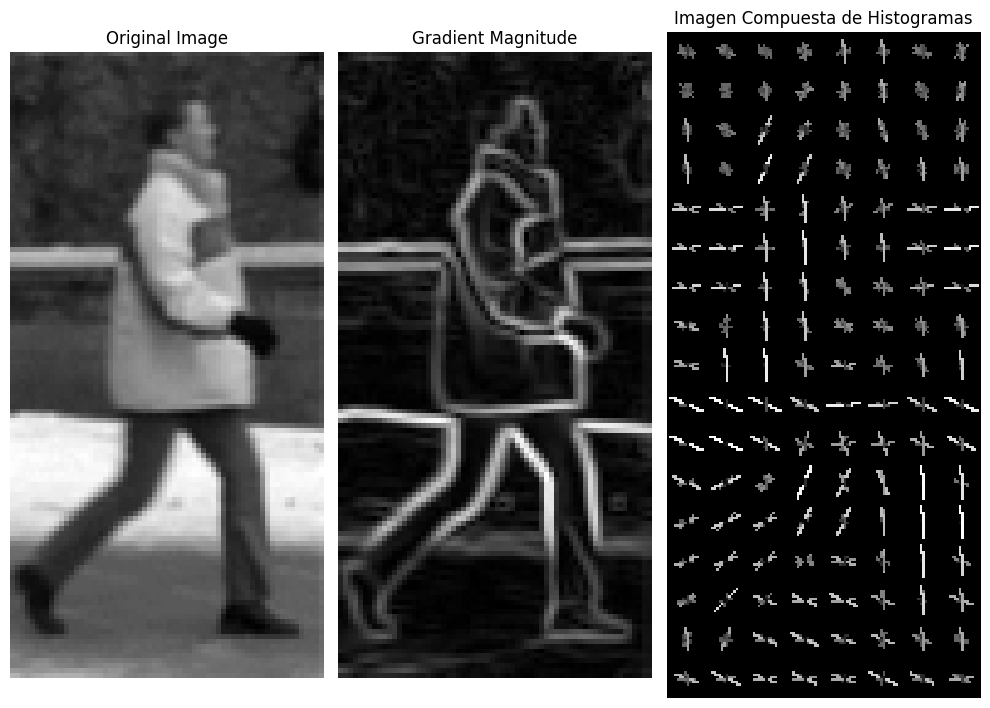

In [254]:
import matplotlib.pyplot as plt

composite_image = create_composite_image(histograms)
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

ax[0].imshow(resized_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(magnitude, cmap='gray')
ax[1].set_title('Gradient Magnitude')
ax[1].axis('off')


ax[2].imshow(composite_image, cmap='gray', interpolation='nearest')
ax[2].set_title("Imagen Compuesta de Histogramas")
ax[2].axis('off')

plt.tight_layout()
plt.show()
